# Lab 2 - Math 178, Spring 2024

You are encouraged to work in groups of up to 3 total students, but each student should submit their own file. (It's fine for everyone in the group to submit the same link.)

Put the full names of everyone in your group (even if you're working alone) here. This makes grading easier.

**Names**:

The attached data is a very slightly altered form of this [Kaggle dataset](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data).

* Read in the attached credit card fraud data and look at its contents.  Pay particular attention to the column data types.  In this lab, we are interested in predicting the contents of the "fraud" column.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pandas.api.types import is_bool_dtype
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [2]:
df = pd.read_csv("card_fraud.csv")

In [3]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                      bool
used_chip                            bool
used_pin_number                      bool
online_order                         bool
fraud                              object
dtype: object

## Preparing the data

Divide the data into a training set and a test set.  Specify a `random_state` when you call `train_test_split`, so that you get consistent results.  I had trouble in the logistic regression section if my training set was too big, so I recommend using only 10% of the data (still a lot, 100,000 rows) as the training size.  It's possible that using even a smaller training size is appropriate.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("fraud", axis=1), df["fraud"], train_size=10**5, random_state=3)

* Imagine we always predict "Not Fraud".  What accuracy score (i.e., proportion correctly classified) do we get on the training set?  On the test set?  Why can there not be any overfitting here?

In [5]:
y_baseline = np.full_like(y_train, "Not Fraud")

In [6]:
p = accuracy_score(y_baseline, y_train)
p

0.91352

In [7]:
accuracy_score(np.full_like(y_test, "Not Fraud"), y_test)

0.9124944444444445

In [8]:
(y_test == "Not Fraud").mean()

0.9124944444444445

## Logistic regression - using scikit-learn

Fit a scikit-learn `LogisticRegression` classification model to the training data.  Because it is such a large dataset, I ran into errors/warnings during the `fit` stage if I had instantiated the `LogisticRegression` object using the default parameters.   To combat this, I used only 10% of the data in my training set, I increased the default number of iterations, and I changed the solver.  You can see the options in the `LogisticRegression` class [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).  Originally I also increased the default tolerance, but it seems like this makes the model less accurate, so try to avoid increasing the tolerance if possible.  Don't be surprised if fitting the model takes up to 5 minutes.  If you're having issues, try increasing the tolerance very slightly.

In [9]:
clf = LogisticRegression(tol=0.001, solver="sag", max_iter=10000)

In [10]:
clf = LogisticRegression(solver="sag", max_iter=10000)

In [11]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, solver='sag')

* What is the accuracy score on the training set?  On the test set?  Are you concerned about overfitting?

In [12]:
clf.score(X_train, y_train)

0.93907

In [13]:
clf.score(X_test, y_test)

0.9381833333333334

* Evaluate the scikit-learn `confusion_matrix` function on the test data ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).  Which entry in this confusion matrix would you focus the most on, if you were a bank?  Why? 

In [14]:
confusion_matrix(y_test, clf.predict(X_test))

array([[ 31559,  47196],
       [  8439, 812806]])

In [15]:
predictions = clf.predict(X_test)

In [16]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)

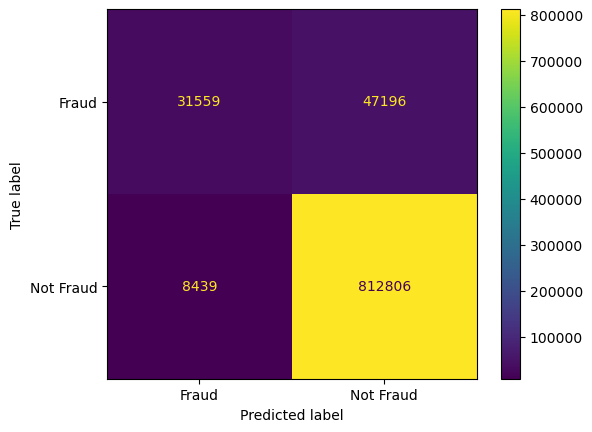

In [18]:
disp.plot()

## Naive Bayes - by hand

Our goal in this section is to perform Naive Bayes "by hand" (or at least without using a scikit-learn model).  Recall that Naive Bayes is based on the following formula, taken from Section 4.4 of ISLP:

![Formula 4.30](naiveBayes.png)

In our case, $k$ will represent either "Fraud" or "Not Fraud".  The function $f_{ki}(x_i)$ represents the probability (or probability density) of the i-th predictor being $x_i$ in class $k$.  To estimate these functions $f_{ki}$, we will use the first and third bullet points beneath Equation (4.30) in ISLP, according to whether the variable is a float type or a Boolean type.  The term $\pi_k$ represents *prior* probability of class $k$ (*prior* meaning without dependence on the predictors $x_i$).

Strategy:
* We first compute the values $\pi_k$.
* We then (prepare to) compute the functions $f_{ki}$ when $i$ represents a float column.
* We then (prepare to) compute the functions $f_{ki}$ when $i$ represents a Boolean column.

* Define a dictionary `prior_dct` representing the two prior values $\pi_{Fraud}$ and $\pi_{Not Fraud}$, as in the following template.
```
prior_dct = {
    "Fraud": ???,
    "Not Fraud": ???
}
```
Reality check: the two values should sum to (approximately) 1.

In [19]:
p = (y_train == "Fraud").mean()

prior_dct = {
    "Fraud": p,
    "Not Fraud": 1-p
}

In [20]:
prior_dct

{'Fraud': 0.08648, 'Not Fraud': 0.91352}

In [21]:
p1 = (y_train != "Fraud").mean()
print(p1)

0.91352


In [22]:
p = (y_train == "Fraud").mean()
p1 = (y_train == "Not Fraud").mean()
#p1 = (y_train != "Fraud").mean()

prior_dct_v2 = {
    "Fraud": p,
    "Not Fraud": p1
}
prior_dct_v2

{'Fraud': 0.08648, 'Not Fraud': 0.91352}

* It's temporarily convenient here to have `X_train` and `y_train` together in the same DataFrame.  Concatenate these together along the columns axis and name the result `df_train`.

In [38]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
396645,31.349377,0.205349,0.938398,True,True,False,True,Not Fraud
23311,1.296644,1.320207,4.292744,False,False,False,True,Fraud
898602,1.920492,3.845230,0.536337,True,True,False,False,Not Fraud
717543,62.282390,2.345352,0.691888,True,False,False,False,Not Fraud
777825,0.954158,7.821139,0.568286,False,False,False,True,Not Fraud
...,...,...,...,...,...,...,...,...
572344,3.169406,3.070521,0.684865,True,False,False,True,Not Fraud
452227,4.656197,2.625558,1.997541,True,False,False,False,Not Fraud
601337,218.787696,0.070694,0.624996,True,True,False,True,Not Fraud
722584,3.990084,2.192464,0.833127,True,True,False,False,Not Fraud


* Write a function `Gaussian_helper` which takes a DataFrame input `df` and two string inputs, a class `k` (which will be "Not Fraud" or "Fraud" in our case) and a column name `col` of one of the float columns.  The output should be a dictionary with keys `"mean"` and `"std"`, representing the mean and the standard deviation for the given column within the given class, as in the first bullet point after (4.30).  

Comment: To find the mean and standard deviation, you can use the formulas in (4.20) (take the square root of the variance to get the standard deviation), but I think it's easier to just let pandas compute these for you, using the `mean` and `std` methods of a pandas Series.  It's possible pandas will use $n$ instead of the $n-K$ in Equation (4.20), but that shouldn't be significant here because $n$ is so big and $K=2$. 

Here is a possible template:
```
def Gaussian_helper(df, k, col):
    output_dct = {}
    ... # one or more lines here
    output_dct["mean"] = ...
    output_dct["std"] = ...
    return output_dct
```

In [24]:
def Gaussian_helper(df, k, col):
    output_dct = {}
    ser = df.loc[df["fraud"] == k, col]
    output_dct["mean"] = ser.mean()
    output_dct["std"] = ser.std()
    return output_dct

* Similarly, write a function `Boolean_helper` which takes a DataFrame input `df` and two string inputs, a class `k` (which will be "Not Fraud" or "Fraud" in our case) and a column name `col` of one of the Boolean columns.  The output should be a dictionary with keys `True` and `False`, representing the proportion of these values within the given class.  For an example, see the third bullet point after (4.30) in the textbook.

Comment: Make sure your keys are `bool` values, not strings.

In [25]:
def Boolean_helper(df, k, col):
    output_dct = {}
    ser = df.loc[df["fraud"] == k, col]
    p = ser.mean()
    output_dct[True] = p
    output_dct[False] = 1-p
    return output_dct

* Check your helper functions by comparing a few of their outputs to the following.  (I feel like there is probably a nice way to use the following DataFrame directly and never define the helper functions, but I did not succeed in doing that.)

```
df_train.groupby("fraud").mean()
```

In [26]:
df_train.groupby("fraud").mean()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
fraud,,,,,,,
Fraud,66.947603,13.072574,5.989062,0.880666,0.253353,0.002891,0.947849
Not Fraud,22.762880,4.293053,1.414935,0.882509,0.362696,0.108547,0.621639


In [27]:
Gaussian_helper(df_train, "Not Fraud", 'distance_from_last_transaction')

{'mean': 4.293053194701276, 'std': 18.698566502771733}

In [39]:
Gaussian_helper(df_train, "Fraud", 'distance_from_last_transaction')

{'mean': 13.07257438605343, 'std': 48.91467336597028}

In [28]:
Boolean_helper(df_train, "Not Fraud", 'used_chip')

{True: 0.36269594535423416, False: 0.6373040546457658}

Here is an example of applying the Gaussian probability density function with mean 10 and standard deviation 4 to every entry in a column, without explicitly using any loops.

```
from scipy.stats import norm

norm.pdf(X_train["distance_from_last_transaction"], loc=10, scale=4)
```

You should view the outputs as representing the probability (densities) of the given Gaussian distribution producing the input values.

In [29]:
from scipy.stats import norm

norm.pdf(X_train["distance_from_last_transaction"], loc=10, scale=4)

array([0.00497561, 0.00947053, 0.03053078, ..., 0.00457932, 0.01484402,
       0.00744476])

Here is an example of using a dictionary to replace every value in a column.  Think of the values in this dictionary as our estimated probabilities.

In [30]:
temp_dct = {True: 0.71, False: 0.29}

X_train["used_chip"].map(temp_dct)

396645    0.71
23311     0.29
898602    0.71
717543    0.29
777825    0.29
          ... 
572344    0.29
452227    0.29
601337    0.71
722584    0.71
71530     0.29
Name: used_chip, Length: 100000, dtype: float64

Momentarily fix the class $k$ to be "Fraud".  We are going to compute the numerator of Equation (4.30) for every row of `X_train`.  (Here we switch back to using `X_train` rather than `df_train`.)

Do all of the following in a single code cell.  (The reason for not separating the cells is so that the entire cell can be run again easily.)

* Assign `k = "Fraud"`.
* Copy the `X_train` DataFrame into a new DataFrame called `X_temp`.  Use the `copy` method.
* For each column of `X_temp`, use `Gaussian_helper` or `Boolean_helper`, as appropriate, to replace each value $x_i$ with $f(x_i)$, where $f$ is as in (4.30).  You can use a for loop to loop over the columns, but within a fixed column, you should not need to use a for loop (in other words, you should not need to loop over the rows, only over the columns).  The following imports might be helpful for determining the data types (make the imports outside of any for loop).
```
from pandas.api.types import is_bool_dtype, is_float_dtype
```

Comment: Your code should be changing the `X_temp` entries but not the `X_train` entries.  When you are finished, `X_temp` will be a DataFrame containing probabilities, all corresponding to the "Fraud" class.

* For each row, multiply all entries in that row.  (Hint.  DataFrames have a `prod` method.)  Also multiply by the prior probability of "Fraud".  (Use `k`, do not type `"Fraud"`.)  The end result should be a pandas Series corresponding to the numerator of (4.30), for each row of `X_train`.  Don't be surprised if the numbers are very small, like around $10^{-10}$.

In [31]:
from pandas.api.types import is_bool_dtype, is_float_dtype

In [32]:
k = "Fraud"
X_temp = X_train.copy()

for c in X_temp.columns:
    if is_float_dtype(X_train[c]):
        dct = Gaussian_helper(df_train, k, c)
        loc = dct["mean"]
        scale = dct["std"]
        X_temp[c] = norm.pdf(X_temp[c], loc=loc, scale=scale)
    elif is_bool_dtype(X_train[c]):
        dct = Boolean_helper(df_train, k, c)
        X_temp[c] = X_temp[c].map(dct)

X_temp.prod(axis=1)*prior_dct[k]

396645    2.033245e-08
23311     1.084820e-08
898602    9.706474e-10
717543    3.315339e-09
777825    7.144284e-09
              ...     
572344    5.347774e-08
452227    3.615439e-09
601337    1.001793e-08
722584    1.023674e-09
71530     3.222440e-09
Length: 100000, dtype: float64

* Once the code is working, wrap the whole thing into another for loop, corresponding to `k = "Fraud"` and `k = "Not Fraud"`, putting the two resulting pandas Series into a length 2 dictionary with keys `"Fraud"` and `"Not Fraud"`.  Call this dictionary `num_dct`, because it represents the numerators of (4.30).

In [37]:
num_dct = {}

for k in ["Fraud", "Not Fraud"]:
    X_temp = X_train.copy()

    for c in X_temp.columns:
        if is_float_dtype(X_train[c]):
            dct = Gaussian_helper(df_train, k, c)
            loc = dct["mean"]
            scale = dct["std"]
            X_temp[c] = norm.pdf(X_temp[c], loc=loc, scale=scale)
        elif is_bool_dtype(X_train[c]):
            dct = Boolean_helper(df_train, k, c)
            X_temp[c] = X_temp[c].map(dct)

    num_dct[k] = X_temp.prod(axis=1)*prior_dct[k]

num_dct

{'Fraud': 396645    2.033245e-08
 23311     1.084820e-08
 898602    9.706474e-10
 717543    3.315339e-09
 777825    7.144284e-09
               ...     
 572344    5.347774e-08
 452227    3.615439e-09
 601337    1.001793e-08
 722584    1.023674e-09
 71530     3.222440e-09
 Length: 100000, dtype: float64,
 'Not Fraud': 396645    5.416763e-06
 23311     3.816276e-07
 898602    2.910761e-06
 717543    4.215607e-06
 777825    1.098875e-06
               ...     
 572344    8.761946e-06
 452227    5.531373e-06
 601337    2.572111e-09
 722584    3.125787e-06
 71530     5.922533e-06
 Length: 100000, dtype: float64}

* Create a new two-column pandas DataFrame with the results using the following code:
```
df_num = pd.DataFrame(num_dct)
```

In [36]:
df_num = pd.DataFrame(num_dct)
df_num

,Fraud,Not Fraud
396645,2.033245e-08,5.416763e-06
23311,1.084820e-08,3.816276e-07
898602,9.706474e-10,2.910761e-06
717543,3.315339e-09,4.215607e-06
777825,7.144284e-09,1.098875e-06
...,...,...
572344,5.347774e-08,8.761946e-06
452227,3.615439e-09,5.531373e-06
601337,1.001793e-08,2.572111e-09
722584,1.023674e-09,3.125787e-06


* What proportion of the values in `X_train` are correctly identified as Fraud using this procedure?  (Note.  We never actually need to compute the denominator in (4.30), since all we care about here is which entry is bigger.)

In [35]:
(df_num.idxmax(axis=1) == y_train).mean()

0.92776

## Submission

* Using the `Share` button at the top right, enable public sharing, and enable Comment privileges. Then submit the created link on Canvas.

## Possible extensions

* I originally wanted us to consider log loss as our error metric, but I decided the lab was already getting rather long, so I removed that.  But in general, log loss is a more refined measure for detecting overfitting than accuracy score.  It should be relatively straightforward to evaluate log loss for the Logistic Regression model.  Compare this to the log loss of a baseline prediction, where we predict the same probability for every row.  I got some errors when I tried to evaluate log loss for the Naive Bayes model and I haven't thought carefully about how to avoid these.
* How do our values compare to using the scikit-learn Naive Bayes model?  (I don't think this will be easy, because you will have to treat the Gaussian and the Boolean portions separately.  There might also be some discrepancy due to our method of estimating standard deviation, but I don't think that is crucial.  I have not tried this myself, so there could also be other discrepancies I'm not anticipating.)
* How does KNN compare in performance?  (What's the optimal number of neighbors?)  I haven't tried this, and I think the training size might be too large, so be prepared to reduce the size of the training set further.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8bfb68aa-a490-4655-9dfb-cfa0891b3675' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>